# Logistic Regression Example

### 生成数据集， 看明白即可无需填写代码
#### '<font color="blue">+</font>' 从高斯分布采样 (X, Y) ~ N(3, 6, 1, 1, 0).<br>
#### '<font color="green">o</font>' 从高斯分布采样  (X, Y) ~ N(6, 3, 1, 1, 0)<br>

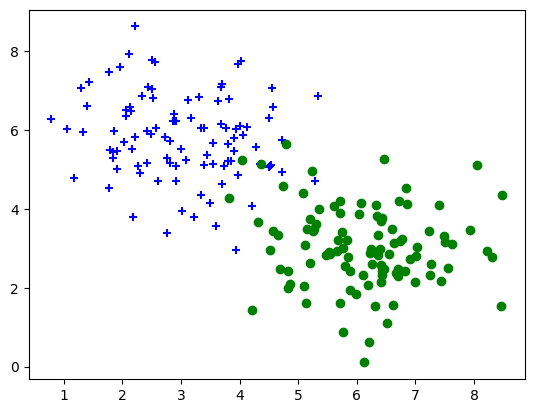

In [1]:
# 导入必要的库
import tensorflow as tf
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

# 设置每个类别的数据点数量
dot_num = 100

# 生成第一类数据点（正类，标签为1）
# 在点(3, 6)附近生成符合正态分布的数据点
x_p = np.random.normal(3., 1, dot_num)  # x坐标：均值3，标准差1
y_p = np.random.normal(6., 1, dot_num)  # y坐标：均值6，标准差1
y = np.ones(dot_num)                    # 标签：全部设为1（正类）
C1 = np.array([x_p, y_p, y]).T         # 组合成形状为(100, 3)的数组：[x, y, label]

# 生成第二类数据点（负类，标签为0）
# 在点(6, 3)附近生成符合正态分布的数据点
x_n = np.random.normal(6., 1, dot_num)  # x坐标：均值6，标准差1
y_n = np.random.normal(3., 1, dot_num)  # y坐标：均值3，标准差1
y = np.zeros(dot_num)                   # 标签：全部设为0（负类）
C2 = np.array([x_n, y_n, y]).T         # 组合成形状为(100, 3)的数组：[x, y, label]

# 可视化两类数据点
plt.scatter(C1[:, 0], C1[:, 1], c='b', marker='+')  # 蓝色'+'表示正类
plt.scatter(C2[:, 0], C2[:, 1], c='g', marker='o')  # 绿色'o'表示负类

# 合并两类数据并随机打乱
data_set = np.concatenate((C1, C2), axis=0)  # 合并为形状(200, 3)的数组
np.random.shuffle(data_set)                  # 随机打乱数据顺序，避免训练时的偏差

## 建立模型
建立模型类，定义loss函数，定义一步梯度下降过程函数

填空一：实现sigmoid的交叉熵损失函数(不使用tf内置的loss 函数)

In [2]:
# 定义一个很小的常数，用于数值稳定性，防止log(0)的情况
epsilon = 1e-12

class LogisticRegression():
    """逻辑回归模型类"""
    def __init__(self):
        # 初始化权重矩阵W，形状为[2, 1]，对应2个输入特征
        # 使用小的随机值初始化，范围在[-0.1, 0.1]之间
        self.W = tf.Variable(shape=[2, 1], dtype=tf.float32, 
            initial_value=tf.random.uniform(shape=[2, 1], minval=-0.1, maxval=0.1))
        
        # 初始化偏置项b，形状为[1]，初始值为0
        self.b = tf.Variable(shape=[1], dtype=tf.float32, initial_value=tf.zeros(shape=[1]))
        
        # 将需要训练的参数放入列表，方便优化器使用
        self.trainable_variables = [self.W, self.b]
    
    @tf.function  # 装饰器，将函数编译为TensorFlow图，提高执行效率
    def __call__(self, inp):
        """
        前向传播函数
        inp: 输入数据，形状为(N, 2)，N是样本数量
        返回: 预测概率，形状为(N, 1)
        """
        # 计算线性组合：z = X*W + b
        logits = tf.matmul(inp, self.W) + self.b  # shape(N, 1)
        # 通过sigmoid函数将logits转换为概率值[0, 1]
        pred = tf.nn.sigmoid(logits)
        return pred

@tf.function
def compute_loss(pred, label):
    """
    计算损失函数和准确率
    pred: 模型预测概率，形状为(N, 1)
    label: 真实标签，形状为(N,)
    返回: (损失值, 准确率)
    """
    # 确保label是TensorFlow张量
    if not isinstance(label, tf.Tensor):
        label = tf.constant(label, dtype=tf.float32)
    
    # 将pred从(N, 1)压缩为(N,)，与label形状匹配
    pred = tf.squeeze(pred, axis=1)
    
    '''============================='''
    # 输入label shape(N,), pred shape(N,)
    # 输出 losses shape(N,) 每一个样本一个loss
    # todo 填空一，实现sigmoid的交叉熵损失函数(不使用tf内置的loss函数)
    
    # 为了数值稳定性，将预测值限制在 [epsilon, 1-epsilon] 范围内
    # 防止log(0)或log(1)导致的数值问题
    #tf.clip_by_value 是 TensorFlow 中一个常用的张量操作函数，它的作用是将张量中的每个元素限制（裁剪）在一个指定的最小值和最大值范围内。
    pred = tf.clip_by_value(pred, epsilon, 1 - epsilon)
    
    # 计算二元交叉熵损失：-[y * log(p) + (1-y) * log(1-p)]
    # 当y=1时，损失为-log(p)，鼓励p接近1
    # 当y=0时，损失为-log(1-p)，鼓励p接近0
    losses = -(label * tf.math.log(pred) + (1 - label) * tf.math.log(1 - pred))
    '''============================='''
    
    # 计算所有样本的平均损失
    loss = tf.reduce_mean(losses)
    
    # 计算准确率：将概率转换为0/1预测，然后与真实标签比较
    pred = tf.where(pred > 0.5, tf.ones_like(pred), tf.zeros_like(pred))  # 阈值为0.5
    accuracy = tf.reduce_mean(tf.cast(tf.equal(label, pred), dtype=tf.float32))
    
    return loss, accuracy

@tf.function
def train_one_step(model, optimizer, x, y):
    """
    执行一步训练
    model: 逻辑回归模型
    optimizer: 优化器（如Adam、SGD等）
    x: 输入特征，形状为(N, 2)
    y: 真实标签，形状为(N,)
    返回: (损失值, 准确率, 更新后的权重W, 更新后的偏置b)
    """
    # 使用GradientTape记录前向传播过程，用于自动求导
    with tf.GradientTape() as tape:
        # 前向传播：计算预测值
        pred = model(x)
        # 计算损失和准确率
        loss, accuracy = compute_loss(pred, y)
    
    # 反向传播：计算损失对模型参数的梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 使用优化器更新模型参数
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # 返回当前步的训练结果
    return loss, accuracy, model.W, model.b

### 实例化一个模型，进行训练

In [3]:
if __name__ == '__main__':
    model = LogisticRegression()
    opt = tf.keras.optimizers.SGD(learning_rate=0.01)
    x1, x2, y = list(zip(*data_set))
    
    # 将数据转换为 float32 类型的 TensorFlow 张量
    x = tf.constant(list(zip(x1, x2)), dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    
    animation_fram = []
    
    for i in range(200):
        loss, accuracy, W_opt, b_opt = train_one_step(model, opt, x, y)
        animation_fram.append((W_opt.numpy()[0, 0], W_opt.numpy()[1, 0], b_opt.numpy(), loss.numpy()))
        if i%20 == 0:
            print(f'loss: {loss.numpy():.4}\t accuracy: {accuracy.numpy():.4}')

loss: 0.6753	 accuracy: 0.5
loss: 0.506	 accuracy: 0.955
loss: 0.4143	 accuracy: 0.96
loss: 0.3549	 accuracy: 0.965
loss: 0.3138	 accuracy: 0.965
loss: 0.2837	 accuracy: 0.965
loss: 0.2608	 accuracy: 0.965
loss: 0.2429	 accuracy: 0.965
loss: 0.2283	 accuracy: 0.965
loss: 0.2164	 accuracy: 0.965


## 结果展示，无需填写代码

正在创建动画...
正在保存 GIF 文件...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22984\2555391375.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  frame_text.set_text('Timestep = %d/%d\nLoss = %.4f\nW1=%.3f, W2=%.3f\nBias=%.3f' %


GIF 文件已保存为: logistic_regression_animation.gif
显示动画:


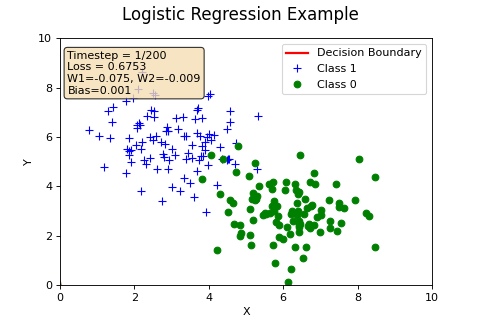

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image, display

# 创建图形和坐标轴
f, ax = plt.subplots(figsize=(6,4))
f.suptitle('Logistic Regression Example', fontsize=15)
plt.ylabel('Y')
plt.xlabel('X')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)

# 初始化绘图元素
line_d, = ax.plot([], [], 'r-', linewidth=2, label='Decision Boundary')
C1_dots, = ax.plot([], [], '+', c='b', markersize=8, label='Class 1')
C2_dots, = ax.plot([], [], 'o', c='g', markersize=6, label='Class 0')

# 设置动画写入器为 pillow（用于生成 GIF）
plt.rcParams['animation.writer'] = 'pillow'

# 添加文本显示当前状态
frame_text = ax.text(0.02, 0.95, '', horizontalalignment='left', 
                     verticalalignment='top', transform=ax.transAxes, 
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 添加图例
ax.legend(loc='upper right')

def init():
    """初始化动画"""
    line_d.set_data([], [])
    C1_dots.set_data([], [])
    C2_dots.set_data([], [])
    frame_text.set_text('')
    return (line_d,) + (C1_dots,) + (C2_dots,) + (frame_text,)

def animate(i):
    """动画函数"""
    # 获取当前帧的参数
    a = animation_fram[i][0]  # W1
    b = animation_fram[i][1]  # W2
    c = animation_fram[i][2]  # bias
    loss = animation_fram[i][3]  # loss
    
    # 计算决策边界
    xx = np.arange(0, 10, step=0.1)
    if abs(b) > 1e-6:  # 避免除零错误
        yy = -(a * xx + c) / b  # 决策边界方程：ax + by + c = 0 => y = -(ax + c)/b
        line_d.set_data(xx, yy)
    else:
        # 如果 b 接近 0，决策边界是垂直线
        if abs(a) > 1e-6:
            x_boundary = -c / a
            line_d.set_data([x_boundary, x_boundary], [0, 10])
        else:
            line_d.set_data([], [])
    
    # 设置数据点
    C1_dots.set_data(C1[:, 0], C1[:, 1])
    C2_dots.set_data(C2[:, 0], C2[:, 1])
    
    # 更新文本信息
    frame_text.set_text('Timestep = %d/%d\nLoss = %.4f\nW1=%.3f, W2=%.3f\nBias=%.3f' % 
                       (i+1, len(animation_fram), loss, a, b, c))
    
    return (line_d,) + (C1_dots,) + (C2_dots,) + (frame_text,)

# 创建动画
print("正在创建动画...")
anim = animation.FuncAnimation(f, animate, init_func=init,
                               frames=len(animation_fram), interval=100, blit=True, repeat=True)

# 保存为 GIF
print("正在保存 GIF 文件...")
anim.save('logistic_regression_animation.gif', writer='pillow', fps=10, dpi=80)
print("GIF 文件已保存为: logistic_regression_animation.gif")

# 在 Jupyter 中显示 GIF
print("显示动画:")
display(Image('logistic_regression_animation.gif'))

# 关闭图形以释放内存
plt.close(f)